Classification of After-Effect Success
---
In this notebook, features that were previously identified as important (SplitBeltAnalsyis_AfterEffect_FeatureSelection.ipynd) are used with several models.  The top-performing models are listed and the interpretable models are further visualized.

** After-Effects **

After-Effects indicate the amount that subjects gait was recalibrated by the split-belt gait training. In other words, the After-Effects indicate how much an individual's gait changed due to gait training. So a non-zero After-Effects means that the gait changed, where values close to zero indicate minimal changes in gait due to training.  If gait retraining was successful, the gait following training should look different than it did before gait training (non-zero After-Effects).  Although After-Effects are continuous, here we are classifying those whose gait training was successful (i.e., gait changed due to training) versus those whose gait training was not successful (i.e., no change in gait due to training).

Import Data
---

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt  

df = pd.read_csv("CleanDataBase.csv")
df.head()

,ID,GroupNum,Height,Weight,Age,Male,RightLeg,AdaptationDuration,Abrupt,MidSpeed,...,IsCatch,Stroke,TextSpeedRatio,BMI,Young,TMSteadyGood,TMSteadyPositive,TMAfterGood,DeltaAda,DeltaAdaGood
0,B001,1,160.0,60.9,20.0,0,1,604,1,1100,...,1,0,2.0,23.789062,1,1,0,1,0.291812,1
1,B003,1,174.0,68.0,20.0,0,1,602,1,1100,...,1,0,2.0,22.460034,1,1,0,1,0.220894,1
2,B004,1,159.0,59.2,20.0,1,1,603,1,1000,...,1,0,2.0,23.416795,1,0,0,1,0.198431,1
3,BC001,1,160.0,60.9,20.0,0,1,601,1,1100,...,1,0,2.0,23.789062,1,1,0,1,0.220999,1
4,BC004,1,165.0,65.0,20.0,1,1,600,1,1100,...,1,0,2.0,23.875115,1,0,0,1,0.355004,1


In [3]:
# set random seed to increase repeatability
import numpy as np
RSEED=37
np.random.seed(RSEED)

After-Effectes Features and Targets
---

Using features selected from a Random Forrest:

In [4]:
from patsy import dmatrices

Y, X = dmatrices('TMAfterGood ~ MidBase + SpeedDifference + SpeedRatio + AdaptationDuration + Age + \
     C(Abrupt)*Height +  C(Abrupt)*C(IsCatch) + AdaptationDuration*Age + Age*C(Young) + \
     EarlyA*AdaptationDuration + MidBase*C(IsCatch) +  SpeedDifference*EarlyA + Weight*BMI + \
    SpeedRatio*EarlyA*C(IsCatch) + C(Abrupt)*C(Young)*C(Stroke)',
    df, return_type="dataframe")

df_Interactions = pd.concat([X,Y], axis=1)

feature_cols = ['MidBase', 'SpeedDifference', 'SpeedRatio', 'AdaptationDuration', 'Age', \
     'C(Abrupt)[T.1]:Height',  'C(Abrupt)[T.1]:C(IsCatch)[T.1]', 'AdaptationDuration:Age', 'Age:C(Young)[T.1]', \
     'EarlyA:AdaptationDuration', 'MidBase:C(IsCatch)[T.1]', 'SpeedRatio:EarlyA', 'Weight:BMI', \
    'SpeedRatio:EarlyA:C(IsCatch)[T.1]', 'C(Abrupt)[T.1]:C(Young)[T.1]:C(Stroke)[T.1]']

target_cols = "TMAfterGood"

Split data into training and testing sets
---

In [5]:
Features = df_Interactions[feature_cols]
Target = df_Interactions[target_cols]

In [6]:
# Split data into training and testing set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Features,Target,test_size = 0.2)

y_test = y_test.values.ravel()
y_train = y_train.values.ravel()

Up-Sampling
---
Check and correct any inbalance in the data set.

Based on: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

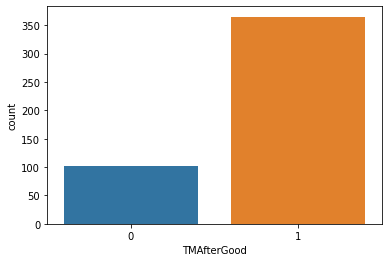

In [7]:
import seaborn as sns # Also to visualize
sns.countplot(x = target_cols, data = df)
plt.show()

In [8]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X, columns = feature_cols)

X_train = os_data_X
y_train = os_data_y

Mass Modeling
---

In [9]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, 
AdaBoostClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

clfs = {'DT':   DecisionTreeClassifier(max_depth = 4),
        'RFC3':  RandomForestClassifier(max_depth = 3),
        'RFC4':  RandomForestClassifier(max_depth = 4),
        'RFC5':  RandomForestClassifier(max_depth = 5),
        'ET':   ExtraTreesClassifier(max_depth = 4),
        'LR':   LogisticRegression(max_iter = 9000),
        'SGD':  SGDClassifier(loss = 'log'),
        'GB':   GradientBoostingClassifier(learning_rate = 0.05, subsample = 0.5, max_depth = 4, n_estimators = 10),
        'NB':   GaussianNB(),
        'KNN':  KNeighborsClassifier(1),
        'SVC1': SVC(kernel = "linear", C = 0.025),
        'SVC2': SVC(gamma = 2, C = 1),
        'GPC':  GaussianProcessClassifier(1.0 * RBF(1.0)),
        'MLP':  MLPClassifier(alpha = 1, max_iter = 1000),
        'ABC':  AdaBoostClassifier(),
        'QDA':  QuadraticDiscriminantAnalysis()}

In [10]:
sel_clfs = [ 'DT', 'ET', 'RFC3', 'LR', 'SGD','GB', 'NB', 'KNN', 'GPC',  'MLP', 'ABC', 'SVC1', 'SVC2']

Initialize plotting functions:

In [11]:
calc_threshold = lambda x,y: 0 if x < y else 1 

In [12]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.show()

In [13]:
from sklearn.metrics import accuracy_score

def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])

        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
        
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('% Predicted > Each Thresholds')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()
    plt.clf() 

Gini Coefficient: https://medium.com/@limavallantin/metrics-to-measure-machine-learning-model-performance-e8c963665476

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Recall Baseline: 1.0 Test: 0.89
Precision Baseline: 0.79 Test: 0.92
Accuracy Baseline: 0.5 Test: 0.85
Roc Baseline: 0.5 Test: 0.87
Gini coefficient Baseline: 0 Test: 0.75
Confusion matrix, without normalization


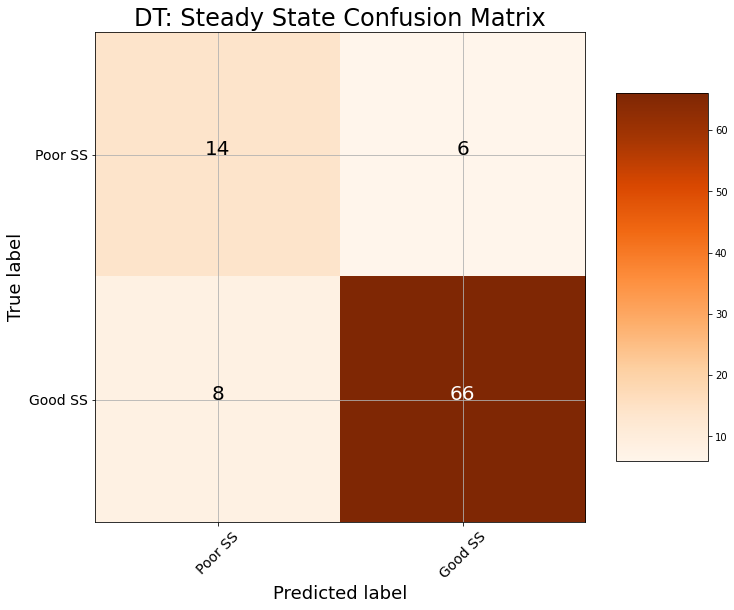

0.98


<Figure size 432x288 with 0 Axes>

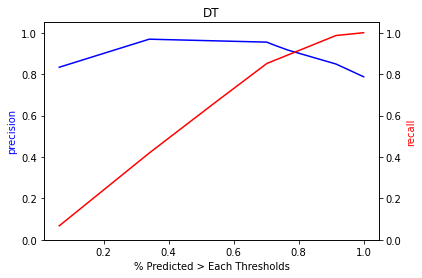

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=4, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Recall Baseline: 1.0 Test: 0.84
Precision Baseline: 0.79 Test: 0.91
Accuracy Baseline: 0.5 Test: 0.81
Roc Baseline: 0.5 Test: 0.88
Gini coefficient Baseline: 0 Test: 0.77
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

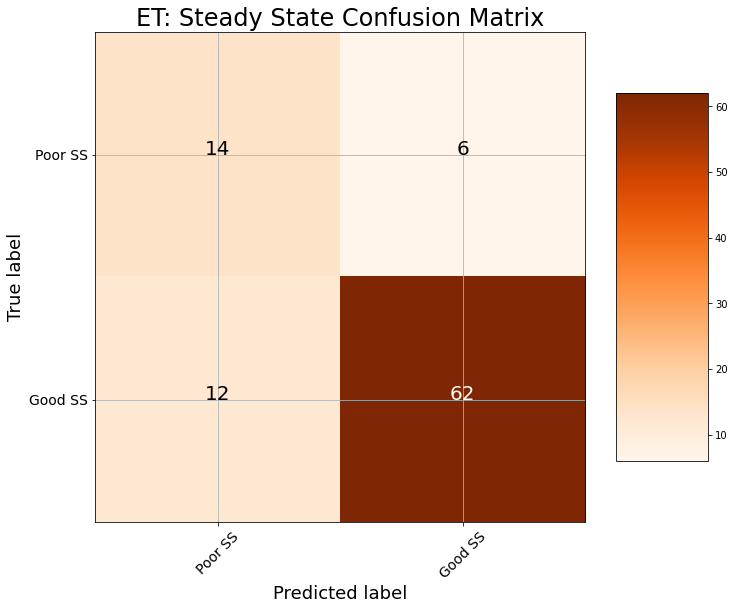

0.5674446778193962


<Figure size 432x288 with 0 Axes>

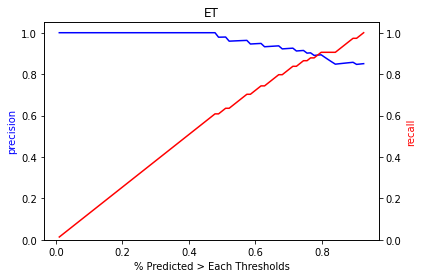

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Recall Baseline: 1.0 Test: 0.84
Precision Baseline: 0.79 Test: 0.93
Accuracy Baseline: 0.5 Test: 0.82
Roc Baseline: 0.5 Test: 0.86
Gini coefficient Baseline: 0 Test: 0.73
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

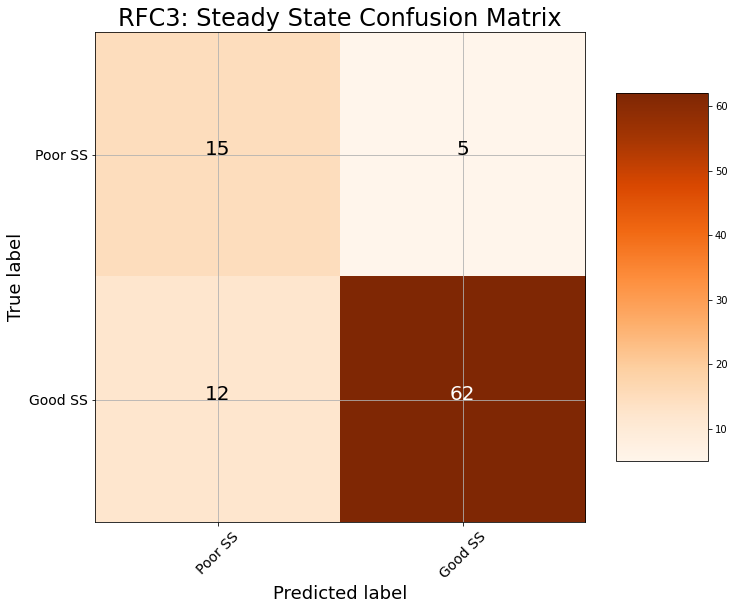

0.7447277055235992


<Figure size 432x288 with 0 Axes>

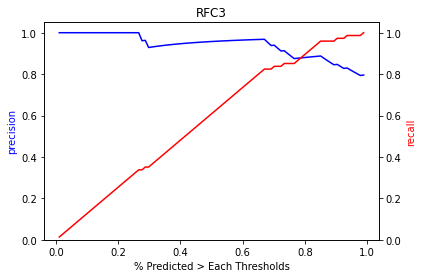

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=9000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recall Baseline: 1.0 Test: 0.8
Precision Baseline: 0.79 Test: 0.89
Accuracy Baseline: 0.5 Test: 0.77
Roc Baseline: 0.5 Test: 0.81
Gini coefficient Baseline: 0 Test: 0.62
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

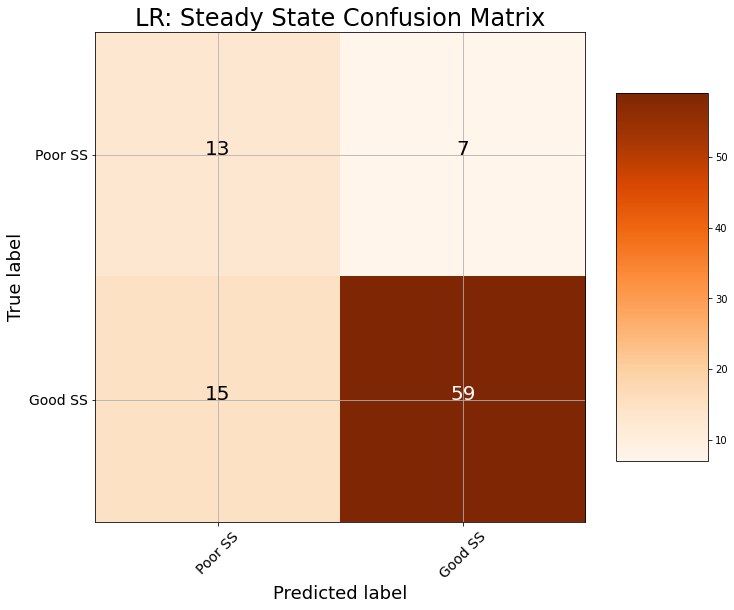

0.6336518414431346


<Figure size 432x288 with 0 Axes>

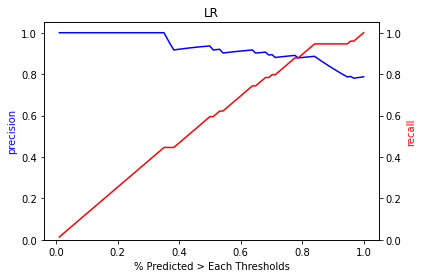

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Recall Baseline: 1.0 Test: 0.95
Precision Baseline: 0.79 Test: 0.83
Accuracy Baseline: 0.5 Test: 0.81
Roc Baseline: 0.5 Test: 0.62
Gini coefficient Baseline: 0 Test: 0.25
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

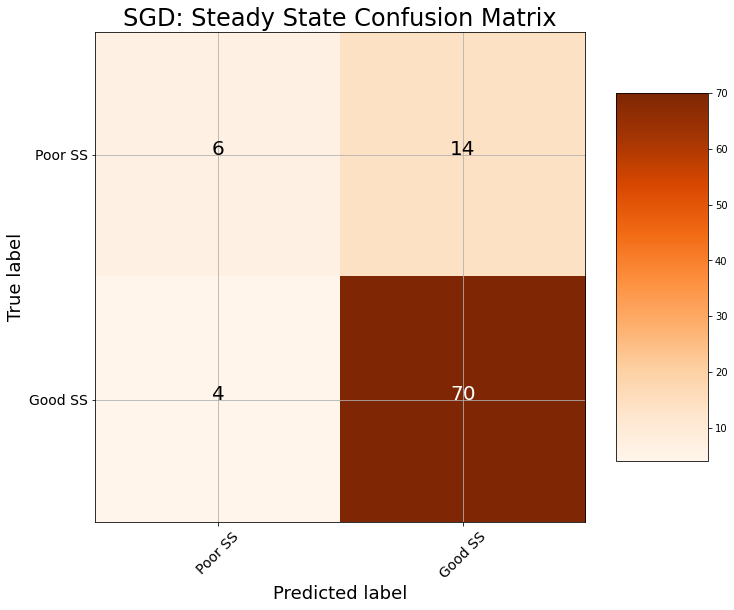

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Recall Baseline: 1.0 Test: 0.92
Precision Baseline: 0.79 Test: 0.92
Accuracy Baseline: 0.5 Test: 0.87
Roc Baseline: 0.5 Test: 0.93
Gini coefficient Baseline: 0 Test: 0.86
Confusion matrix, without normalization


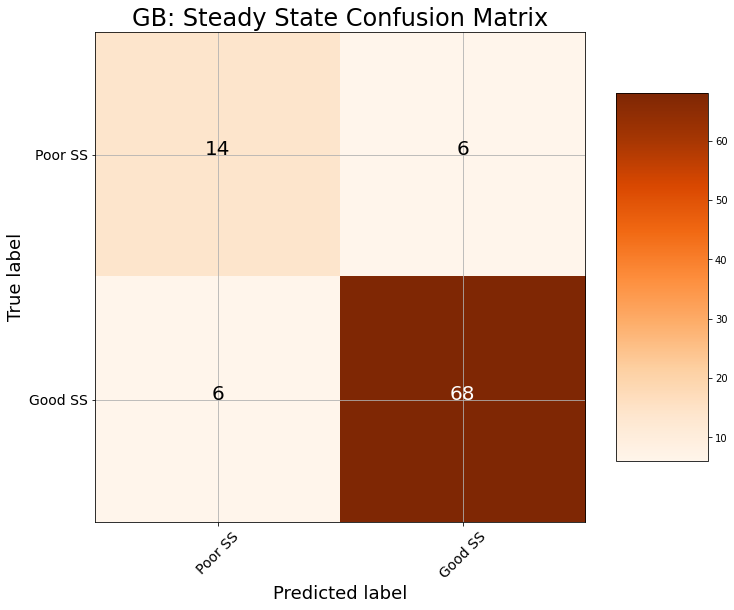

0.6632276745591911


<Figure size 432x288 with 0 Axes>

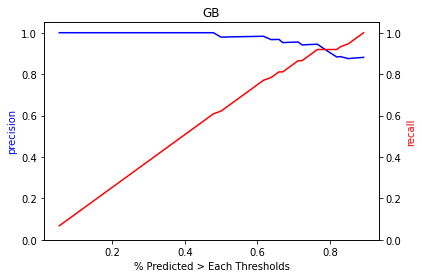

GaussianNB(priors=None, var_smoothing=1e-09)
Recall Baseline: 1.0 Test: 0.68
Precision Baseline: 0.79 Test: 0.89
Accuracy Baseline: 0.5 Test: 0.68
Roc Baseline: 0.5 Test: 0.75
Gini coefficient Baseline: 0 Test: 0.5
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

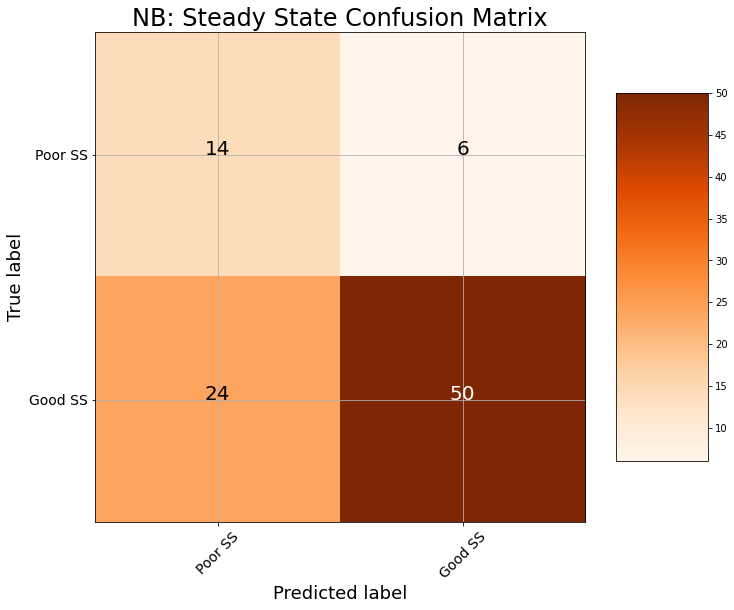

0.9059026971490134


<Figure size 432x288 with 0 Axes>

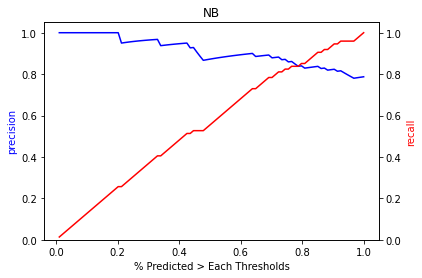

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
Recall Baseline: 1.0 Test: 0.69
Precision Baseline: 0.79 Test: 0.86
Accuracy Baseline: 0.5 Test: 0.67
Roc Baseline: 0.5 Test: 0.64
Gini coefficient Baseline: 0 Test: 0.29
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

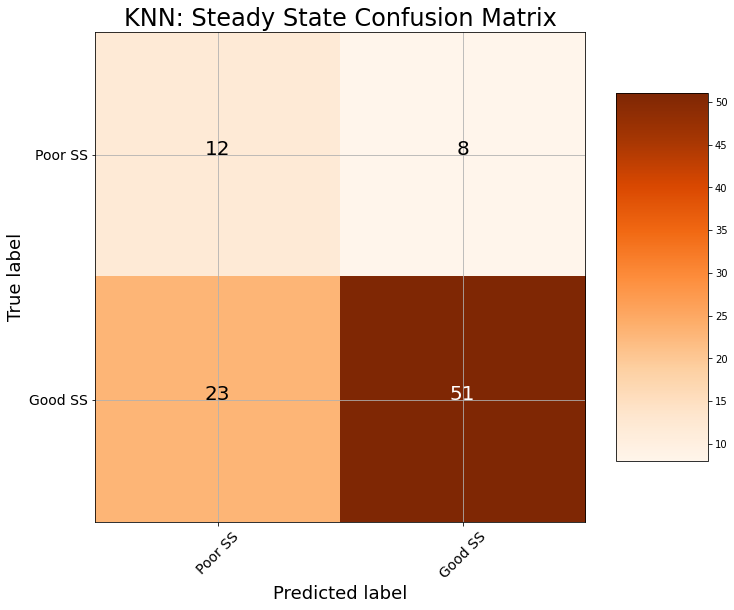

GaussianProcessClassifier(copy_X_train=True, kernel=1**2 * RBF(length_scale=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)
Recall Baseline: 1.0 Test: 0.78
Precision Baseline: 0.79 Test: 0.84
Accuracy Baseline: 0.5 Test: 0.71
Roc Baseline: 0.5 Test: 0.69
Gini coefficient Baseline: 0 Test: 0.38
Confusion matrix, without normalization


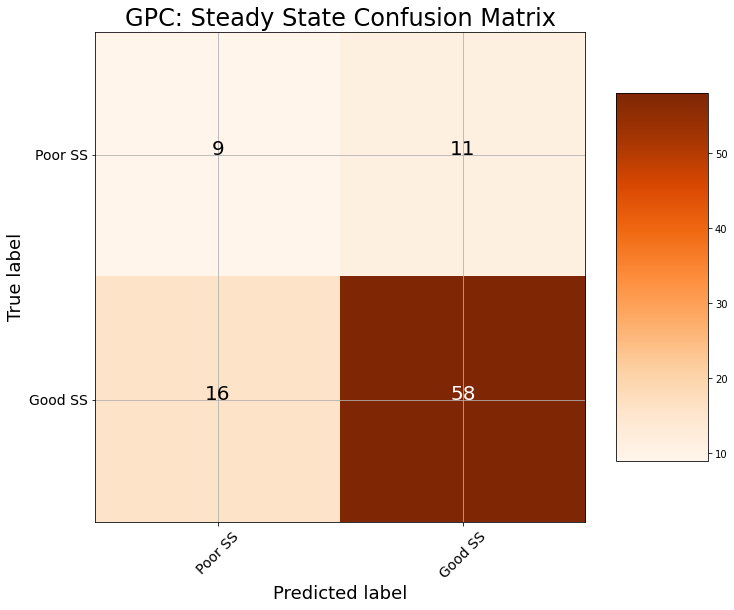

0.6758259174784484


<Figure size 432x288 with 0 Axes>

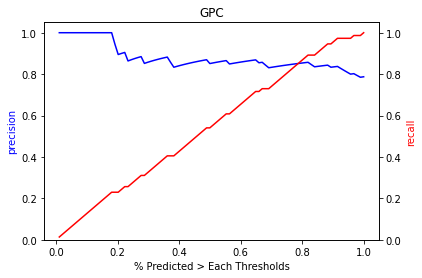

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Recall Baseline: 1.0 Test: 0.41
Precision Baseline: 0.79 Test: 0.86
Accuracy Baseline: 0.5 Test: 0.48
Roc Baseline: 0.5 Test: 0.67
Gini coefficient Baseline: 0 Test: 0.35
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

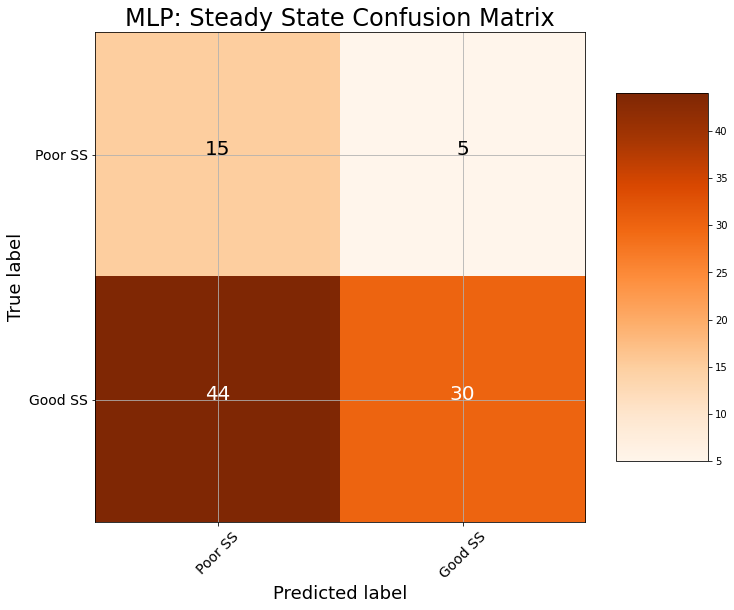

0.9999999999999993


<Figure size 432x288 with 0 Axes>

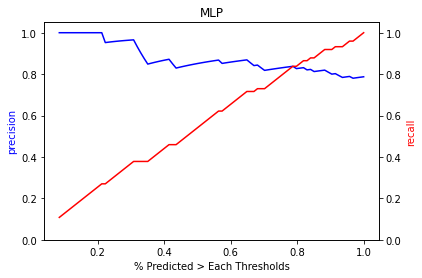

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Recall Baseline: 1.0 Test: 0.91
Precision Baseline: 0.79 Test: 0.93
Accuracy Baseline: 0.5 Test: 0.87
Roc Baseline: 0.5 Test: 0.88
Gini coefficient Baseline: 0 Test: 0.75
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

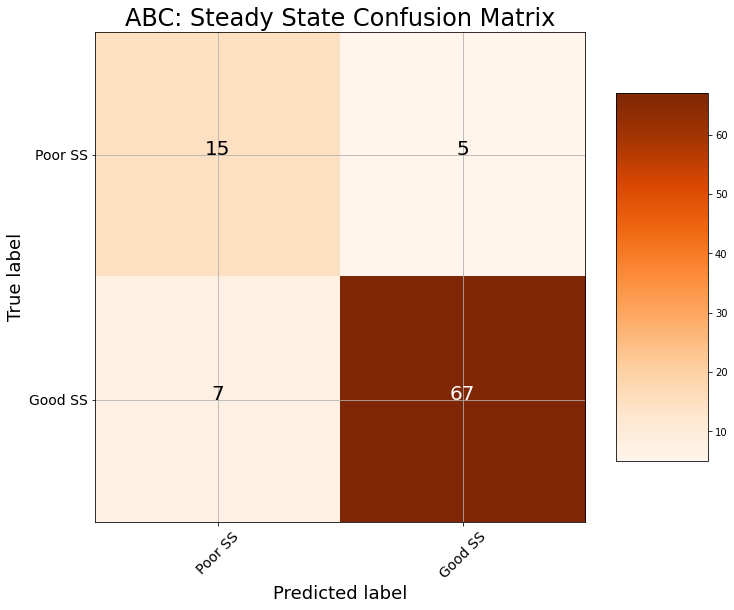

0.5077427921968208


<Figure size 432x288 with 0 Axes>

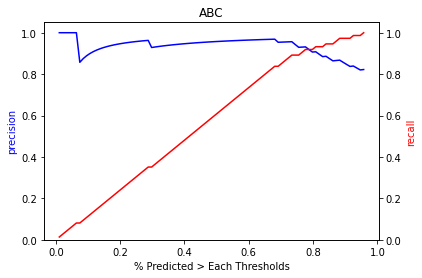

SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Recall Baseline: 1.0 Test: 0.8
Precision Baseline: 0.79 Test: 0.91
Accuracy Baseline: 0.5 Test: 0.78
Roc Baseline: 0.5 Test: 0.88
Gini coefficient Baseline: 0 Test: 0.75
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

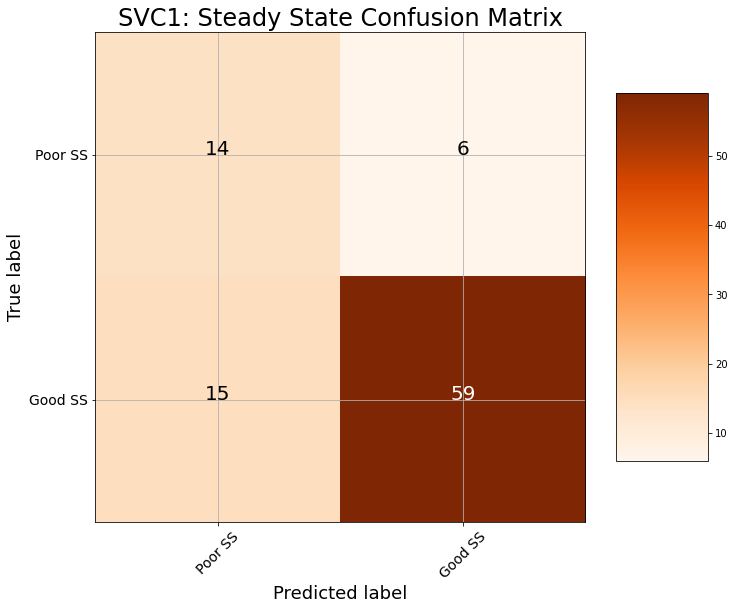

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Recall Baseline: 1.0 Test: 1.0
Precision Baseline: 0.79 Test: 0.79
Accuracy Baseline: 0.5 Test: 0.79
Roc Baseline: 0.5 Test: 0.88
Gini coefficient Baseline: 0 Test: 0.75
Confusion matrix, without normalization


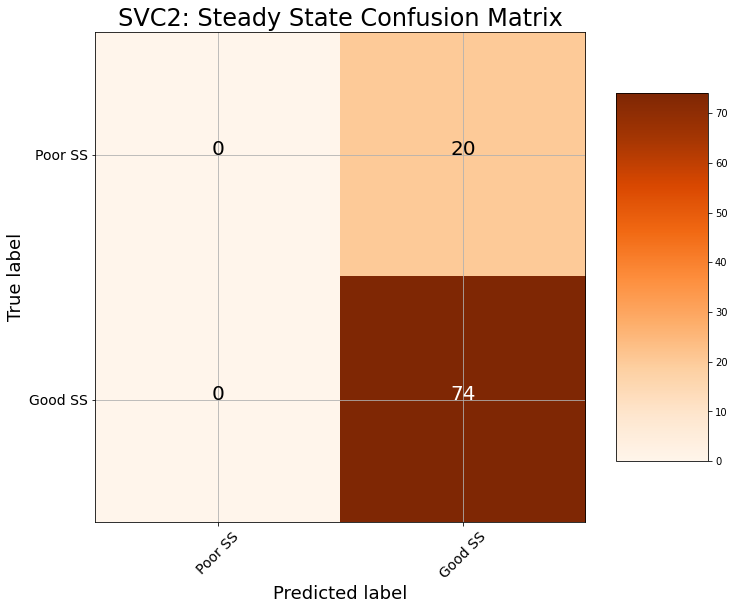

In [14]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, precision_recall_curve
import math

for clfNM in sel_clfs:
    clf = clfs[clfNM]
    print(clf)
    clf.fit( X_train, y_train )
    predicted = clf.predict(X_test)
    expected = np.array(y_test)
    
    try:
        y_score = clf.predict_proba(X_test)[:,1]  
        predicted_prob = np.array(y_score)
    except AttributeError:
        y_score[1] = 10000
    
    # Evaluation: Recall, Precision, and Accuracy
    baseline = {}
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    baseline['accuracy'] = 0.5
    baseline['Gini Coefficient'] = 0
    
    results = {}
    results['recall'] = recall_score(y_test, predicted)
    results['precision'] = precision_score(y_test, predicted)
    results['accuracy'] = accuracy_score(y_test, predicted)
    try:
        results['roc'] = roc_auc_score(y_test, predicted_prob)#NEW
        results['Gini Coefficient'] = (2*roc_auc_score(y_test, predicted_prob))-1#NEW
    except NameError:
        results['roc'] = {}
        results['Gini Coefficient'] = {}
    
    for metric in ['recall', 'precision', 'accuracy', 'roc', 'Gini Coefficient']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)}')
    
    # Evaluation: Visualize Confusion Matrix
    plot_confusion_matrix(confusion_matrix(expected, predicted),
                        classes = ['Poor SS', 'Good SS'],
                      title = clfNM + ': Steady State Confusion Matrix')

    # Evaluation: Precision Recall Curves
    if (np.isnan(y_score[1]) != True) & (y_score[1] < 1 ):
        print(y_score[1])
        plot_precision_recall_n(expected, predicted_prob, clfNM)

**Best Models**

DecisionTreeClassifier:
- Recall Baseline: 1.0 Test: 0.89
- Precision Baseline: 0.79 Test: 0.92
- Accuracy Baseline: 0.5 Test: 0.85
- Roc Baseline: 0.5 Test: 0.87
- Gini coefficient Baseline: 0 Test: 0.75

GradientBoostingClassifier:
- Recall Baseline: 1.0 Test: 0.92
- Precision Baseline: 0.79 Test: 0.92
- Accuracy Baseline: 0.5 Test: 0.87
- Roc Baseline: 0.5 Test: 0.93
- Gini coefficient Baseline: 0 Test: 0.86

AdaBoostClassifier:
- Recall Baseline: 1.0 Test: 0.91
- Precision Baseline: 0.79 Test: 0.93
- Accuracy Baseline: 0.5 Test: 0.87
- Roc Baseline: 0.5 Test: 0.88
- Gini coefficient Baseline: 0 Test: 0.75

Model Summary
---

In conclusion, the After-Effects (i.e., "TMAfterGood") are able to be **classified with Recall, Precision, and Accuracy scores greater than 0.85**.  In particular, the Descision Trees, Gradient Boost, and AdaBoost classifiers perform consistently well.

Final Decision Tree
---

In [77]:
from sklearn.tree import export_graphviz
import pydot
import matplotlib.image as mpimg

def SaveAndVisualizeForest(model, figName, FeatureNames):
    
    try:
        estimator = model.estimators_[1]
    except AttributeError:
                estimator = model

    export_graphviz(estimator, out_file = figName + '.dot', feature_names = FeatureNames,
                rounded = True, precision = 1, class_names = ['goodAE', 'badAE'], filled = True)

    # Use dot file to create a graph
    (graphy, ) = pydot.graph_from_dot_file(figName + '.dot')

    # Write graph to a png file
    graphy.write_png(figName + '.png'); 
    
    #Visualize for notebook
    img = mpimg.imread(figName + '.png')
    fig = plt.figure()
    fig.set_size_inches(30,10)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

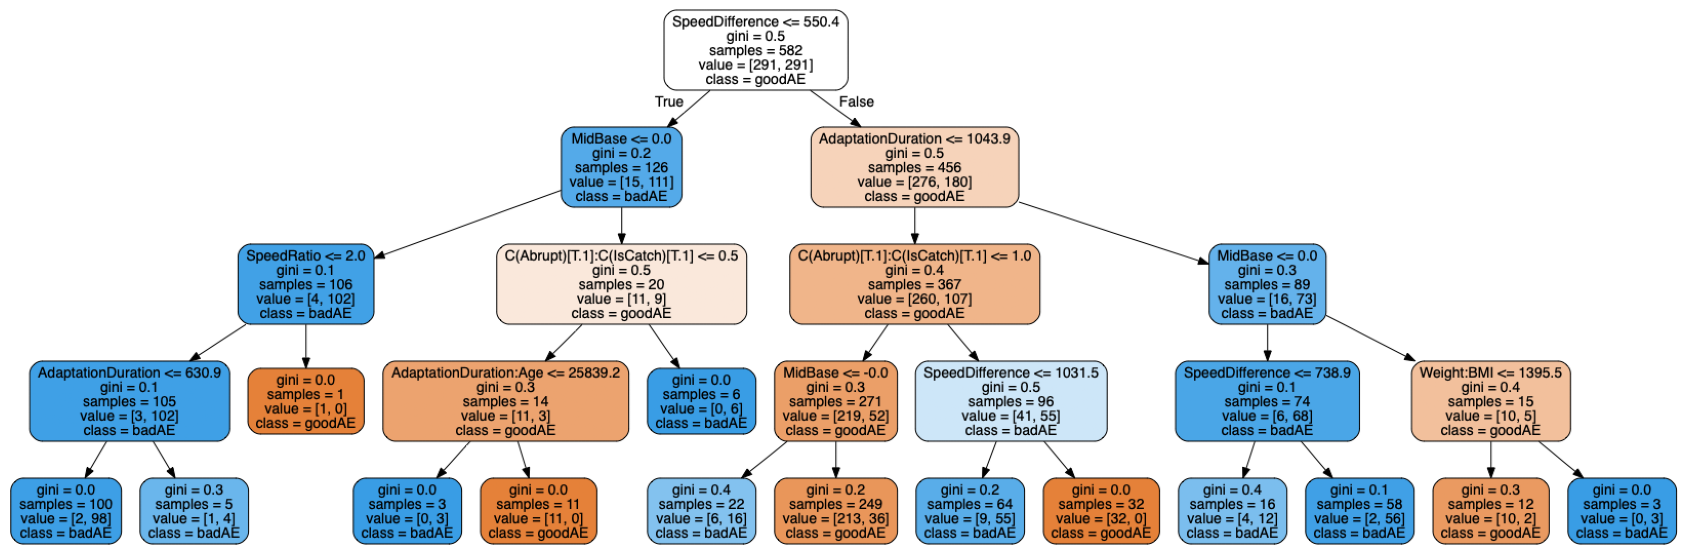

In [79]:
clf = clfs['DT']
clf = clf.fit( X_train, y_train )

SaveAndVisualizeForest(clf, 'AE_DT', feature_cols)

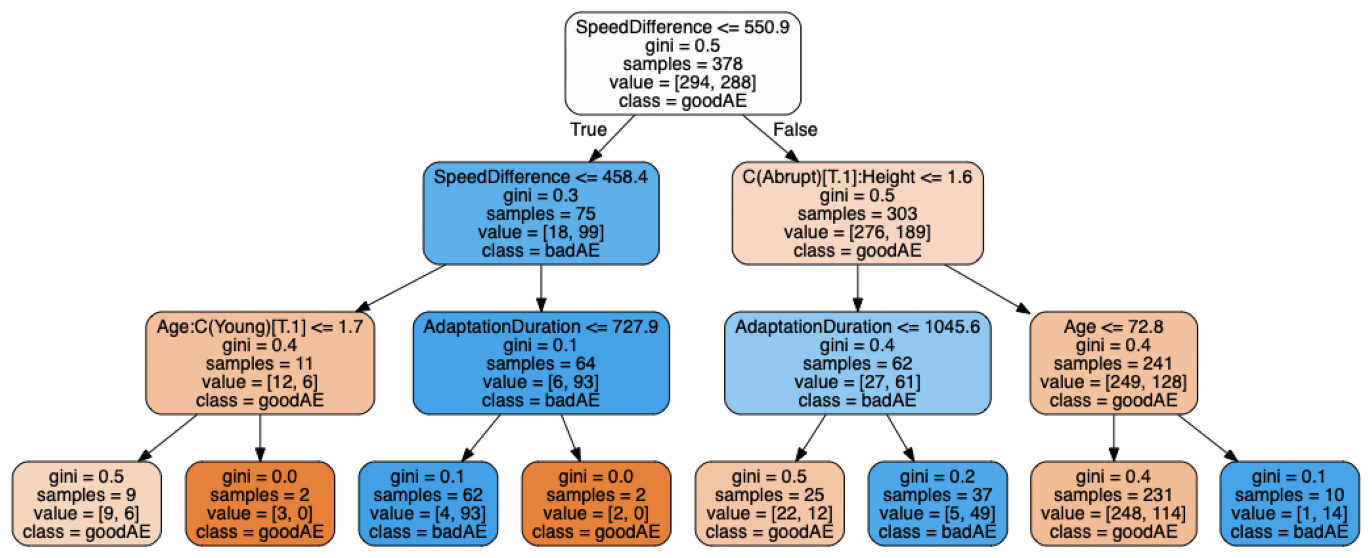

In [81]:
clf = clfs['RFC3']
clf = clf.fit( X_train, y_train )

SaveAndVisualizeForest(clf, 'AE_RF3', feature_cols)

Implications of Models
---

The overall importance of the SpeedDifference compared to SpeedRatio is of great interest as SpeedRatio, not SpeedDifference, is what is controlled for during split-belt studies.

The influence of AdaptationDuration and Age is consistent with current literature on split-belt gait training.